<a href="https://colab.research.google.com/github/pvpogorelova/metrics_24_25/blob/main/sem_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Выбросы и мультиколлинеарность. PCA

import pandas as pd # работа с таблицами
import numpy as np # математические функции и матрицы
import matplotlib.pyplot as plt # графики
import seaborn as sns # еще более классные графики
import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import shapiro # тест Шапиро – Уилка
from sklearn.decomposition import PCA # функция PCA, вычисляющая главные компоненты
from sklearn.preprocessing import StandardScaler # стандартизация признаков

In [26]:
get_ipython().system('pip install rdatasets') # наборы данных
# !pip install pyreadstat # чтение spss/stata данных
from rdatasets import data
# from pyreadstat import read_sav, set_value_labels

In [13]:
reg = smf.ols('price_sq ~ livesp + dist + metrdist + walk + brick + floor', data = data).fit()

In [14]:
# Анализ выбросов
# Выведем таблицу, содержащую различные показатели

influence = reg.get_influence()
inf_sum = influence.summary_frame()

print(inf_sum.head())

   dfb_Intercept  dfb_livesp  dfb_dist  dfb_metrdist  dfb_walk  dfb_brick  \
0      -0.003400    0.025858 -0.023008      0.006270 -0.013480  -0.041913   
1       0.025495   -0.040343  0.006995     -0.007252  0.015740  -0.000697   
2      -0.000882   -0.005694  0.011792     -0.008990  0.004372   0.013433   
3       0.000081   -0.000166  0.000080     -0.000058  0.000135  -0.000043   
4      -0.083646    0.120417  0.034595     -0.018548 -0.142914   0.115108   

   dfb_floor       cooks_d  standard_resid  hat_diag  dffits_internal  \
0  -0.015722  4.425220e-04       -0.984566  0.003185        -0.055657   
1   0.013039  3.612748e-04        0.802872  0.003908         0.050288   
2   0.004278  5.789933e-05        0.292850  0.004704         0.020132   
3   0.000093  1.360986e-08        0.006974  0.001955         0.000309   
4   0.033738  8.676408e-03        3.805346  0.004177         0.246444   

   student_resid    dffits  
0      -0.984558 -0.055656  
1       0.802802  0.050284  
2       0.2

In [18]:
# Объединим исходные данные с таблицей показателей

results = pd.concat([data, inf_sum], axis = 1)
print(results)

      price  totsp  livesp  kitsp  dist  metrdist  walk  brick  floor  \
0        81     58      40    6.0  12.5         7     1      1      1   
1        75     44      28    6.0  13.5         7     1      0      1   
2       128     70      42    6.0  14.5         3     1      1      1   
3        95     61      37    6.0  13.5         7     1      0      1   
4       330    104      60   11.0  10.5         7     0      1      1   
...     ...    ...     ...    ...   ...       ...   ...    ...    ...   
2035    110     77      45   10.0  12.0         5     0      0      1   
2036     95     60      43    6.0   9.0         5     0      0      1   
2037     95     60      46    5.0  10.5         5     1      0      1   
2038    129     76      48   10.0  12.5         5     0      0      1   
2039    103     64      45    7.0  15.5         5     1      0      1   

      price_sq  ...  dfb_metrdist  dfb_walk  dfb_brick  dfb_floor  \
0     1.396552  ...      0.006270 -0.013480  -0.041913

In [15]:
# 1. Показатель воздействия наблюдения или «разбалансировки»: точки левериджа (h_ii - показатель влияния, рычаг)

leverage = influence.hat_matrix_diag
leverage

array([0.00318536, 0.00390789, 0.00470362, ..., 0.00153133, 0.00223334,
       0.00235111])

In [17]:
# Определим пороговое значение для точек левериджа: 2*k/n
cutoff_leverage = (2*6)/2040
cutoff_leverage

0.0058823529411764705

In [19]:
# Выведем номера всех точек левериджа
high_leverage = pd.DataFrame((results[abs(leverage) > cutoff_leverage]))
high_leverage

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,price_sq,...,dfb_metrdist,dfb_walk,dfb_brick,dfb_floor,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
11,115,77,50,9.0,3.5,7,1,0,0,1.493506,...,0.005140,-0.014262,0.065605,0.069573,2.234852e-03,-1.540663,0.006548,-0.125076,-1.541184,-0.125118
20,170,84,55,11.0,3.0,15,1,1,0,2.023810,...,-0.003353,-0.000367,-0.000547,0.003106,5.855650e-06,-0.073796,0.007471,-0.006402,-0.073778,-0.006401
35,450,125,80,20.0,9.0,3,1,0,1,3.600000,...,-0.101658,0.052857,-0.167656,-0.003891,2.583410e-02,3.851667,0.012043,0.425251,3.864847,0.426706
63,89,51,34,6.0,3.5,10,1,0,0,1.745098,...,-0.000167,-0.000129,0.000420,0.000506,1.816858e-07,-0.012812,0.007688,-0.001128,-0.012809,-0.001127
67,100,78,44,8.0,13.5,20,0,0,1,1.282051,...,-0.005928,0.002471,0.000369,-0.001056,7.068579e-06,-0.088133,0.006330,-0.007034,-0.088111,-0.007032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,148,90,55,8.0,13.5,7,0,1,0,1.644444,...,-0.000093,-0.000410,0.000426,-0.000517,1.181683e-07,0.011552,0.006160,0.000909,0.011550,0.000909
1958,265,136,88,14.0,10.5,10,1,1,1,1.948529,...,-0.020119,-0.013901,-0.012488,-0.000961,3.490445e-03,-1.265749,0.015021,-0.156311,-1.265936,-0.156334
1969,170,86,59,10.0,17.0,10,0,1,1,1.976744,...,0.010142,-0.034563,0.052442,0.009945,1.240495e-03,1.104741,0.007065,0.093185,1.104801,0.093190
2006,151,111,64,16.0,14.5,10,0,1,1,1.360360,...,-0.013647,0.042206,-0.047986,-0.009500,1.485414e-03,-1.254106,0.006568,-0.101970,-1.254283,-0.101984


In [20]:
# 2. Анализ влиятельности наблюдения: DFFITS

dffits = influence.dffits
print(dffits)

(array([-0.05565615,  0.05028401,  0.02012742, ..., -0.02754911,
        0.00925115, -0.00038929]), 0.11715583722580122)


In [21]:
# пороговое значение для DFFITS: cutoff = 2*sqrt(k/n)
import math
cutoff_dffits = 2*math.sqrt(6/2040)
print(cutoff_dffits)

0.10846522890932808


In [22]:
# Выведем наблюдения, являющиеся влиятельными согласно DFFITS

dffits_high = pd.DataFrame((results[abs(inf_sum.dffits) > cutoff_dffits]))
dffits_high

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,price_sq,...,dfb_metrdist,dfb_walk,dfb_brick,dfb_floor,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
4,330,104,60,11.0,10.5,7,0,1,1,3.173077,...,-0.018548,-0.142914,0.115108,0.033738,0.008676,3.805346,0.004177,0.246444,3.818032,0.247266
11,115,77,50,9.0,3.5,7,1,0,0,1.493506,...,0.005140,-0.014262,0.065605,0.069573,0.002235,-1.540663,0.006548,-0.125076,-1.541184,-0.125118
19,110,85,54,10.0,6.0,10,0,1,1,1.294118,...,-0.030055,0.083900,-0.046839,-0.023813,0.002520,-2.049776,0.004181,-0.132818,-2.051392,-0.132923
25,56,68,43,7.0,13.5,10,0,1,1,0.823529,...,-0.021533,0.074153,-0.105087,-0.031857,0.002879,-2.185205,0.004203,-0.141972,-2.187238,-0.142104
35,450,125,80,20.0,9.0,3,1,0,1,3.600000,...,-0.101658,0.052857,-0.167656,-0.003891,0.025834,3.851667,0.012043,0.425251,3.864847,0.426706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,160,68,44,8.0,17.0,5,1,0,1,2.352941,...,-0.052768,0.054262,-0.004407,0.025630,0.002697,2.461998,0.003104,0.137389,2.465070,0.137561
1958,265,136,88,14.0,10.5,10,1,1,1,1.948529,...,-0.020119,-0.013901,-0.012488,-0.000961,0.003490,-1.265749,0.015021,-0.156311,-1.265936,-0.156334
1973,135,105,58,21.0,13.5,15,1,1,1,1.285714,...,-0.063073,-0.023039,-0.054458,-0.016861,0.001791,-1.527586,0.005344,-0.111975,-1.528088,-0.112012
2012,370,111,60,13.0,8.0,5,1,1,1,3.333333,...,-0.049899,0.031173,0.067888,0.033476,0.005089,3.506461,0.002889,0.188743,3.516248,0.189270


In [23]:
# 3. Анализ влиятельности наблюдения: DFBETAS

cut_off = 2 / math.sqrt(2040)
print(cut_off)

0.04428074427700476


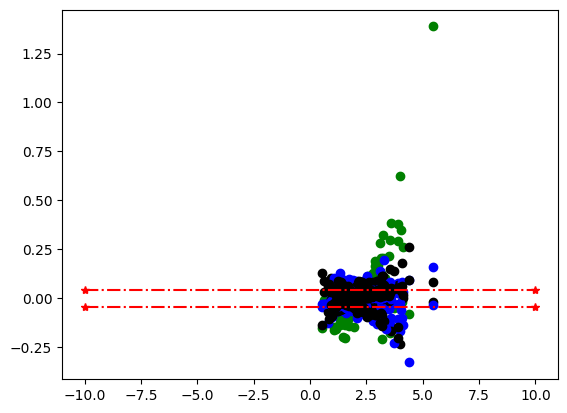

In [32]:
plt.scatter(results.price_sq, results.dfb_livesp, color = "green", marker = "o")
plt.scatter(results.price_sq, results.dfb_metrdist, color = "blue", marker = "o")
plt.scatter(results.price_sq, results.dfb_brick, color = "black", marker = "o")
plt.scatter(results.price_sq, results.dfb_floor, color = "blue", marker = "o")
plt.scatter(results.price_sq, results.dfb_walk, color = "black", marker = "o")
plt.plot((-10,10),(0.044, 0.044), '-.r*')
plt.plot((-10,10),(-0.044, -0.044), '-.r*')

In [33]:
# Выведем номера всех влиятельных наблюдений согласно DFBETAS для переменной Y

high_dfby = pd.DataFrame((results[abs(results.dfb_livesp) > cut_off]))
high_dfby

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,price_sq,...,dfb_metrdist,dfb_walk,dfb_brick,dfb_floor,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
4,330,104,60,11.0,10.5,7,0,1,1,3.173077,...,-0.018548,-0.142914,0.115108,0.033738,0.008676,3.805346,0.004177,0.246444,3.818032,0.247266
35,450,125,80,20.0,9.0,3,1,0,1,3.600000,...,-0.101658,0.052857,-0.167656,-0.003891,0.025834,3.851667,0.012043,0.425251,3.864847,0.426706
45,265,100,56,14.0,7.0,10,0,0,1,2.650000,...,0.031026,-0.084295,-0.068719,0.017315,0.003463,2.379223,0.004264,0.155687,2.381956,0.155866
76,153,87,66,9.0,7.5,10,1,1,1,1.758621,...,-0.020987,-0.011807,-0.020265,-0.010992,0.001091,-1.330181,0.004298,-0.087390,-1.330433,-0.087407
83,350,80,44,14.0,10.5,10,1,1,0,4.375000,...,0.093296,0.093685,0.263621,-0.328154,0.034823,8.125951,0.003678,0.493719,8.259187,0.501814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,420,102,70,20.0,3.0,2,1,1,1,4.117647,...,-0.136835,0.018140,0.002576,0.030301,0.024411,4.791603,0.007387,0.413370,4.817706,0.415622
1958,265,136,88,14.0,10.5,10,1,1,1,1.948529,...,-0.020119,-0.013901,-0.012488,-0.000961,0.003490,-1.265749,0.015021,-0.156311,-1.265936,-0.156334
2002,155,60,40,11.0,7.5,5,1,1,1,2.583333,...,-0.030009,0.017511,0.058043,0.031446,0.001646,1.946500,0.003032,0.107345,1.947837,0.107419
2006,151,111,64,16.0,14.5,10,0,1,1,1.360360,...,-0.013647,0.042206,-0.047986,-0.009500,0.001485,-1.254106,0.006568,-0.101970,-1.254283,-0.101984


In [34]:
# 4. Анализ выбросов: стьюдентизированные остатки

student_resid = influence.resid_studentized_external
print(student_resid)

[-0.98455827  0.8028018   0.29278448 ... -0.7034626   0.19553888
 -0.00801907]


In [35]:
# определим критическое значение для стьюдентизированных остатков

from scipy import stats
crit = stats.t(df=2034).ppf((0.95))
print(crit)

1.6456031193884353


In [36]:
# Выведем номера всех возможных выбросов согласно стьюдентизированным остаткам

high_stud_res = pd.DataFrame((results[abs(student_resid) > crit]))
high_stud_res

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,price_sq,...,dfb_metrdist,dfb_walk,dfb_brick,dfb_floor,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
4,330,104,60,11.0,10.5,7,0,1,1,3.173077,...,-0.018548,-0.142914,0.115108,0.033738,0.008676,3.805346,0.004177,0.246444,3.818032,0.247266
8,225,80,56,9.0,9.0,5,1,1,1,2.812500,...,-0.032991,0.021681,0.053056,0.023609,0.001623,2.195160,0.002352,0.106581,2.197226,0.106681
19,110,85,54,10.0,6.0,10,0,1,1,1.294118,...,-0.030055,0.083900,-0.046839,-0.023813,0.002520,-2.049776,0.004181,-0.132818,-2.051392,-0.132923
25,56,68,43,7.0,13.5,10,0,1,1,0.823529,...,-0.021533,0.074153,-0.105087,-0.031857,0.002879,-2.185205,0.004203,-0.141972,-2.187238,-0.142104
35,450,125,80,20.0,9.0,3,1,0,1,3.600000,...,-0.101658,0.052857,-0.167656,-0.003891,0.025834,3.851667,0.012043,0.425251,3.864847,0.426706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,160,68,44,8.0,17.0,5,1,0,1,2.352941,...,-0.052768,0.054262,-0.004407,0.025630,0.002697,2.461998,0.003104,0.137389,2.465070,0.137561
1966,185,68,47,8.0,4.5,5,1,1,1,2.720588,...,-0.023210,0.010685,0.031768,0.024632,0.001359,1.745178,0.003115,0.097548,1.746057,0.097597
2002,155,60,40,11.0,7.5,5,1,1,1,2.583333,...,-0.030009,0.017511,0.058043,0.031446,0.001646,1.946500,0.003032,0.107345,1.947837,0.107419
2012,370,111,60,13.0,8.0,5,1,1,1,3.333333,...,-0.049899,0.031173,0.067888,0.033476,0.005089,3.506461,0.002889,0.188743,3.516248,0.189270


<Axes: xlabel='metrdist'>

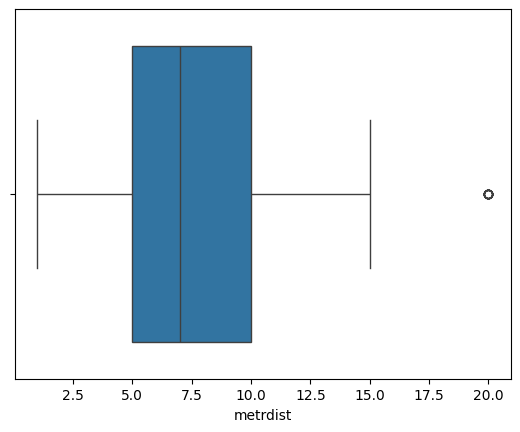

In [41]:
sns.boxplot(x=results["metrdist"])

In [51]:
# Метод главных компонент (Principal Component Analysis)
data = pd.read_excel('dataflats.xlsx')
data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor
0,81,58,40,6.0,12.5,7,1,1,1
1,75,44,28,6.0,13.5,7,1,0,1
2,128,70,42,6.0,14.5,3,1,1,1
3,95,61,37,6.0,13.5,7,1,0,1
4,330,104,60,11.0,10.5,7,0,1,1


In [52]:
data['price_sq'] = data['price']/data['totsp']
data

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,price_sq
0,81,58,40,6.0,12.5,7,1,1,1,1.396552
1,75,44,28,6.0,13.5,7,1,0,1,1.704545
2,128,70,42,6.0,14.5,3,1,1,1,1.828571
3,95,61,37,6.0,13.5,7,1,0,1,1.557377
4,330,104,60,11.0,10.5,7,0,1,1,3.173077
...,...,...,...,...,...,...,...,...,...,...
2035,110,77,45,10.0,12.0,5,0,0,1,1.428571
2036,95,60,43,6.0,9.0,5,0,0,1,1.583333
2037,95,60,46,5.0,10.5,5,1,0,1,1.583333
2038,129,76,48,10.0,12.5,5,0,0,1,1.697368


In [57]:
features = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist'] # добавляем количественные регрессоры в отдельный список
x = data[features] # отбираем признаки
y = data['price_sq'] # выделяем целевую переменную
# Матрица корреляций объясняющих факторов
correlation_matrix = x.corr()
print(correlation_matrix)

             totsp    livesp     kitsp      dist  metrdist
totsp     1.000000  0.862236  0.781479 -0.114698 -0.041426
livesp    0.862236  1.000000  0.573429 -0.197228 -0.052112
kitsp     0.781479  0.573429  1.000000 -0.061832 -0.028499
dist     -0.114698 -0.197228 -0.061832  1.000000  0.099185
metrdist -0.041426 -0.052112 -0.028499  0.099185  1.000000


In [58]:
# Стандартизируем факторы
x_scaled = StandardScaler().fit_transform(x) # стандартизируем регрессоры

In [59]:
# Реализуем PCA. Строим 5 главных компонент
pca_model = PCA(n_components=5)
principalComponents = pca_model.fit_transform(x_scaled)
principaldata = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']) # создаем таблицу, в которую сохраняем значения найденных компонент
principaldata

,PC1,PC2,PC3,PC4,PC5
0,-1.664595,-0.170182,0.382594,-0.235535,-0.019761
1,-3.132676,-0.058395,0.619063,0.778132,0.055991
2,-1.065828,-0.464760,1.553843,-0.575355,0.440988
3,-1.802300,0.046424,0.623437,-0.065274,0.324892
4,2.665792,-0.010419,0.201316,-0.725857,0.426100
...,...,...,...,...,...
2035,0.275382,-0.316997,0.834723,0.330752,0.149290
2036,-1.189425,-1.227353,-0.013890,-0.328122,-0.077456
2037,-1.229762,-0.987383,0.245725,-0.906326,-0.177236
2038,0.429200,-0.226317,0.919538,0.076687,-0.109912


In [9]:
# Добавим зависимую переменную и бинарную переменную walk к набору данных
principaldata['price_sq'] = y
principaldata['walk'] = data['walk']
principaldata

,PC1,PC2,PC3,PC4,PC5,price_sq,walk
0,-1.664595,-0.170182,0.382594,-0.235535,-0.019761,1.396552,1
1,-3.132676,-0.058395,0.619063,0.778132,0.055991,1.704545,1
2,-1.065828,-0.464760,1.553843,-0.575355,0.440988,1.828571,1
3,-1.802300,0.046424,0.623437,-0.065274,0.324892,1.557377,1
4,2.665792,-0.010419,0.201316,-0.725857,0.426100,3.173077,0
...,...,...,...,...,...,...,...
2035,0.275382,-0.316997,0.834723,0.330752,0.149290,1.428571,0
2036,-1.189425,-1.227353,-0.013890,-0.328122,-0.077456,1.583333,0
2037,-1.229762,-0.987383,0.245725,-0.906326,-0.177236,1.583333,1
2038,0.429200,-0.226317,0.919538,0.076687,-0.109912,1.697368,0


[0.50402812 0.21584758 0.18005558 0.08360339 0.01646533]


Text(0.5, 0, 'Главные компоненты')

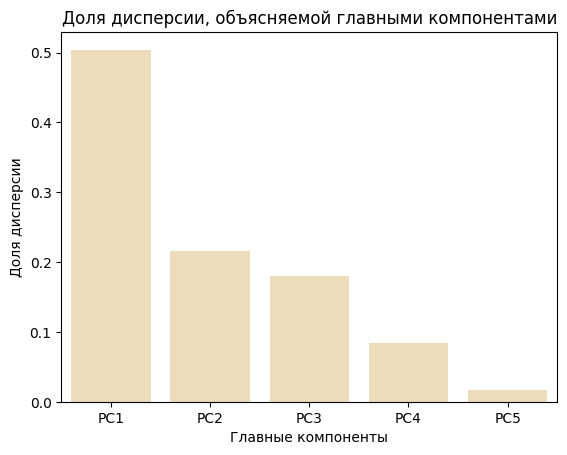

In [10]:
print(pca_model.explained_variance_ratio_)
d = pd.DataFrame({'var':pca_model.explained_variance_ratio_, 'PC':['PC1', 'PC2', 'PC3','PC4','PC5']})
graph = sns.barplot(x = 'PC', y = 'var', data = d, color = 'wheat')
graph.set_title('Доля дисперсии, объясняемой главными компонентами')
graph.set_ylabel('Доля дисперсии')
graph.set_xlabel('Главные компоненты')

In [42]:
# Веса исходных центрированно-нормированных признаков в главных компонентах
pd.DataFrame(pca_model.components_, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = ['totsp', 'livesp', 'kitsp', 'dist', 'metrdist'])

,PC1,PC2,PC3,PC4,PC5
totsp,0.608249,0.566925,0.533475,-0.144766,-0.055457
livesp,0.096260,-0.002993,0.148895,0.662687,0.727600
kitsp,0.051947,-0.047384,0.114671,0.717207,-0.683755
dist,-0.113408,-0.627793,0.754356,-0.154793,-0.000965
metrdist,0.777950,-0.531241,-0.333216,-0.039268,-0.001153


In [43]:
# Матрица нагрузок
loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)

loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5'], index=['totsp', 'livesp', 'kitsp', 'dist', 'metrdist'])
loading_matrix

,PC1,PC2,PC3,PC4,PC5
totsp,0.965830,0.100026,0.049301,-0.073341,0.223269
livesp,0.900212,-0.003110,-0.044970,-0.405995,-0.152464
kitsp,0.847097,0.154719,0.108830,0.487842,-0.095632
dist,-0.229872,0.688610,0.680674,-0.100105,-0.011270
metrdist,-0.088060,0.756062,-0.648926,-0.000624,-0.000331


In [47]:
# Проверим, выполняются ли свойства для матрицы нагрузок
# Свойство 1: сумма квадратов элементов j-го столбца матрицы нагрузок равна дисперсии j-ой главной компоненты
print(np.sum(loading_matrix**2, axis=0))
print(pca_model.explained_variance_)

# Свойство 2: сумма квадратов элементов любой строки матрицы нагрузок равна 1
print(np.sum(loading_matrix**2, axis=1))

PC1    2.521377
PC2    1.079767
PC3    0.900719
PC4    0.418222
PC5    0.082367
dtype: float64
[2.52137659 1.07976717 0.90071943 0.41822196 0.08236703]
totsp       1.00049
livesp      1.00049
kitsp       1.00049
dist        1.00049
metrdist    1.00049
dtype: float64


In [11]:
# Оценим регрессию price_sq на главные компоненты
regr = smf.ols('price_sq ~ PC1 + PC2 + PC3 + PC4 + PC5 + walk', data=principaldata).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_sq   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     173.2
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          3.12e-178
Time:                        12:35:56   Log-Likelihood:                -633.77
No. Observations:                2040   AIC:                             1282.
Df Residuals:                    2033   BIC:                             1321.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6220      0.013    122.630      0.000       1.596       1.648
PC1            0.0975      0.005     21.118      0.000       0.088       0.107
PC2           -0.1322      0.007    -18.574      0.000      -0.146      -0.118
PC3           -0.0597      0.008     -7.688      0.000      -0.075      -0.044
PC4            0.0149      0.011      1.318      0.188      -0.007       0.037
PC5           -0.1173      0.026     -4.592      0.000      -0.167      -0.067
walk           0.1396      0.016      8.692      0.000       0.108       0.171
==============================================================================
Omnibus:                      833.914   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7507.026
Skew:                           1.678   Prob(JB):                         0.00
Kurtosis:                      11.778   Cond. No.                         5.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Оценим регрессию price_sq на главные компоненты, удалив незначимые
regr = smf.ols('price_sq ~ PC1 + PC2 + PC3 + PC5 + walk', data=principaldata).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_sq   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     207.4
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          4.90e-179
Time:                        12:36:18   Log-Likelihood:                -634.64
No. Observations:                2040   AIC:                             1281.
Df Residuals:                    2034   BIC:                             1315.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6224      0.013    122.678      0.000       1.596       1.648
PC1            0.0975      0.005     21.116      0.000       0.088       0.107
PC2           -0.1323      0.007    -18.576      0.000      -0.146      -0.118
PC3           -0.0597      0.008     -7.691      0.000      -0.075      -0.044
PC5           -0.1174      0.026     -4.593      0.000      -0.167      -0.067
walk           0.1390      0.016      8.655      0.000       0.107       0.170
==============================================================================
Omnibus:                      820.693   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7127.174
Skew:                           1.657   Prob(JB):                         0.00
Kurtosis:                      11.536   Cond. No.                         5.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""